# - GoogleNet(inception v1)

https://www.analyticsvidhya.com/blog/2018/10/understanding-inception-network-from-scratch/

In [1]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split

import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Input, concatenate, GlobalAveragePooling2D, AveragePooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
img_dir = 'data/Images3'
categories = os.listdir(img_dir)
num_classes = len(categories)

In [3]:
image_w = 224
image_h = 224

In [4]:
X = []
y = []

for index, breed in enumerate(categories):
    label = [0 for i in range(num_classes)]
    label[index] = 1

    image_dir = img_dir + "/" + breed
    files = glob.glob(image_dir+"/*.jpg")
    print(index, ")", breed, " 파일 길이 : ", len(files))
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)

        X.append(data)
        y.append(label)

0 ) n02085620-Chihuahua  파일 길이 :  152
1 ) n02085782-Japanese_spaniel  파일 길이 :  185
2 ) n02085936-Maltese_dog  파일 길이 :  252
3 ) n02086079-Pekinese  파일 길이 :  149
4 ) n02086240-Shih-Tzu  파일 길이 :  214
5 ) n02086646-Blenheim_spaniel  파일 길이 :  188
6 ) n02086910-papillon  파일 길이 :  196
7 ) n02088364-beagle  파일 길이 :  195
8 ) n02088466-bloodhound  파일 길이 :  187
9 ) n02089078-black-and-tan_coonhound  파일 길이 :  159
10 ) n02089867-Walker_hound  파일 길이 :  153
11 ) n02089973-English_foxhound  파일 길이 :  157
12 ) n02091032-Italian_greyhound  파일 길이 :  182
13 ) n02091134-whippet  파일 길이 :  187
14 ) n02093256-Staffordshire_bullterrier  파일 길이 :  155
15 ) n02093647-Bedlington_terrier  파일 길이 :  182
16 ) n02094258-Norwich_terrier  파일 길이 :  185
17 ) n02094433-Yorkshire_terrier  파일 길이 :  164
18 ) n02096294-Australian_terrier  파일 길이 :  196
19 ) n02096585-Boston_bull  파일 길이 :  182
20 ) n02097047-miniature_schnauzer  파일 길이 :  154
21 ) n02097209-standard_schnauzer  파일 길이 :  155
22 ) n02097658-silky_terrier  파일 길이 :  183

In [5]:
X = np.array(X)
y = np.array(y)

In [6]:
n = np.arange(X.shape[0])
np.random.seed(0)
np.random.shuffle(n)

In [7]:
X = X[n]
y = y[n]

In [8]:
print("Images shape after shuffling = ",X.shape,"\nLabels shape after shuffling = ",y.shape)

Images shape after shuffling =  (11411, 224, 224, 3) 
Labels shape after shuffling =  (11411, 65)


In [9]:
X = X.astype(np.float32)
y = y.astype(np.int32)
X = X/255.

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

In [11]:
print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)

print("\nx_val shape = ",x_val.shape)
print("y_val shape = ",y_val.shape)

print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (8215, 224, 224, 3)
y_train shape =  (8215, 65)

x_val shape =  (913, 224, 224, 3)
y_val shape =  (913, 65)

x_test shape =  (2283, 224, 224, 3)
y_test shape =  (2283, 65)


In [12]:
image_generator = ImageDataGenerator(
    rotation_range = 45,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    zoom_range = 0.25,
    horizontal_flip=True,
    fill_mode = 'nearest'
)

In [13]:
image_generator.fit(x_train)

In [14]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [15]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [16]:
input_layer = Input(shape=(image_w, image_h, 3))

x = Conv2D(32, (5, 5), padding='same', strides=(2, 2), activation='relu', name='conv_1_5x5/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=32,
                     filters_3x3_reduce=48,
                     filters_3x3=64,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=48,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=24,
                     filters_pool_proj=32,
                     name='inception_4a')


x1 = AveragePooling2D((3, 3), strides=3)(x)
x1 = Conv2D(64, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(num_classes, activation='softmax', name='auxilliary_output_1')(x1)

x = inception_module(x,
                     filters_1x1=96,
                     filters_3x3_reduce=64,
                     filters_3x3=144,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')


x2 = AveragePooling2D((3, 3), strides=3)(x)
x2 = Conv2D(64, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(num_classes, activation='softmax', name='auxilliary_output_2')(x2)

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=80,
                     filters_3x3=160,
                     filters_5x5_reduce=24,
                     filters_5x5=96,
                     filters_pool_proj=96,
                     name='inception_4c')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=80,
                     filters_3x3=160,
                     filters_5x5_reduce=24,
                     filters_5x5=96,
                     filters_pool_proj=96,
                     name='inception_5')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)
x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(num_classes, activation='softmax', name='output')(x)

In [17]:
model = Model(input_layer, [x, x1, x2], name='inception_v1')
model.summary()

Model: "inception_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_1_5x5/2 (Conv2D)           (None, 112, 112, 32) 2432        input_1[0][0]                    
__________________________________________________________________________________________________
max_pool_1_3x3/2 (MaxPooling2D) (None, 56, 56, 32)   0           conv_1_5x5/2[0][0]               
__________________________________________________________________________________________________
conv_2_3x3/1 (Conv2D)           (None, 56, 56, 64)   18496       max_pool_1_3x3/2[0][0]           
_______________________________________________________________________________________

In [18]:
model.compile(optimizer="adam", loss= 'categorical_crossentropy', metrics=["accuracy"])
K.set_value(model.optimizer.learning_rate, 0.0001)

In [19]:
early_stopping= EarlyStopping(monitor='val_loss', mode ='min', verbose = 1, patience = 10)
model_checkPoint = ModelCheckpoint('GoogleNet.h5', monitor='val_loss', save_best_only = True, mode ='min', verbose = 1)

In [20]:
history = model.fit(image_generator.flow(x_train, y_train, batch_size=128), steps_per_epoch=x_train.shape[0]/200, epochs=100, shuffle=True, callbacks=[early_stopping, model_checkPoint], validation_data=(x_val, y_val))

Epoch 1/100
42/41 [==============================] - ETA: -3s - loss: 12.6763 - output_loss: 4.2647 - auxilliary_output_1_loss: 4.2161 - auxilliary_output_2_loss: 4.1955 - output_accuracy: 0.0167 - auxilliary_output_1_accuracy: 0.0154 - auxilliary_output_2_accuracy: 0.0152
Epoch 00001: val_loss improved from inf to 12.51490, saving model to GoogleNet.h5
42/41 [==============================] - 146s 3s/step - loss: 12.6763 - output_loss: 4.2647 - auxilliary_output_1_loss: 4.2161 - auxilliary_output_2_loss: 4.1955 - output_accuracy: 0.0167 - auxilliary_output_1_accuracy: 0.0154 - auxilliary_output_2_accuracy: 0.0152 - val_loss: 12.5149 - val_output_loss: 4.1722 - val_auxilliary_output_1_loss: 4.1705 - val_auxilliary_output_2_loss: 4.1722 - val_output_accuracy: 0.0164 - val_auxilliary_output_1_accuracy: 0.0175 - val_auxilliary_output_2_accuracy: 0.0252
Epoch 2/100
42/41 [==============================] - ETA: -3s - loss: 12.5392 - output_loss: 4.1944 - auxilliary_output_1_loss: 4.1725 - a

Epoch 11/100
42/41 [==============================] - ETA: -3s - loss: 12.1838 - output_loss: 4.1002 - auxilliary_output_1_loss: 4.0385 - auxilliary_output_2_loss: 4.0451 - output_accuracy: 0.0353 - auxilliary_output_1_accuracy: 0.0482 - auxilliary_output_2_accuracy: 0.0415
Epoch 00011: val_loss improved from 12.11887 to 12.02790, saving model to GoogleNet.h5
42/41 [==============================] - 148s 4s/step - loss: 12.1838 - output_loss: 4.1002 - auxilliary_output_1_loss: 4.0385 - auxilliary_output_2_loss: 4.0451 - output_accuracy: 0.0353 - auxilliary_output_1_accuracy: 0.0482 - auxilliary_output_2_accuracy: 0.0415 - val_loss: 12.0279 - val_output_loss: 4.0809 - val_auxilliary_output_1_loss: 3.9691 - val_auxilliary_output_2_loss: 3.9779 - val_output_accuracy: 0.0394 - val_auxilliary_output_1_accuracy: 0.0570 - val_auxilliary_output_2_accuracy: 0.0613
Epoch 12/100
42/41 [==============================] - ETA: -3s - loss: 12.1690 - output_loss: 4.0961 - auxilliary_output_1_loss: 4.0

Epoch 21/100
42/41 [==============================] - ETA: -3s - loss: 11.7881 - output_loss: 3.9691 - auxilliary_output_1_loss: 3.9126 - auxilliary_output_2_loss: 3.9064 - output_accuracy: 0.0514 - auxilliary_output_1_accuracy: 0.0601 - auxilliary_output_2_accuracy: 0.0582
Epoch 00021: val_loss improved from 11.62230 to 11.53060, saving model to GoogleNet.h5
42/41 [==============================] - 151s 4s/step - loss: 11.7881 - output_loss: 3.9691 - auxilliary_output_1_loss: 3.9126 - auxilliary_output_2_loss: 3.9064 - output_accuracy: 0.0514 - auxilliary_output_1_accuracy: 0.0601 - auxilliary_output_2_accuracy: 0.0582 - val_loss: 11.5306 - val_output_loss: 3.9304 - val_auxilliary_output_1_loss: 3.8050 - val_auxilliary_output_2_loss: 3.7953 - val_output_accuracy: 0.0624 - val_auxilliary_output_1_accuracy: 0.0942 - val_auxilliary_output_2_accuracy: 0.1008
Epoch 22/100
42/41 [==============================] - ETA: -3s - loss: 11.8025 - output_loss: 3.9742 - auxilliary_output_1_loss: 3.9

Epoch 31/100
42/41 [==============================] - ETA: -3s - loss: 11.5242 - output_loss: 3.8634 - auxilliary_output_1_loss: 3.8348 - auxilliary_output_2_loss: 3.8260 - output_accuracy: 0.0675 - auxilliary_output_1_accuracy: 0.0725 - auxilliary_output_2_accuracy: 0.0698
Epoch 00031: val_loss did not improve from 11.21949
42/41 [==============================] - 147s 3s/step - loss: 11.5242 - output_loss: 3.8634 - auxilliary_output_1_loss: 3.8348 - auxilliary_output_2_loss: 3.8260 - output_accuracy: 0.0675 - auxilliary_output_1_accuracy: 0.0725 - auxilliary_output_2_accuracy: 0.0698 - val_loss: 11.2768 - val_output_loss: 3.8288 - val_auxilliary_output_1_loss: 3.7230 - val_auxilliary_output_2_loss: 3.7250 - val_output_accuracy: 0.0898 - val_auxilliary_output_1_accuracy: 0.1073 - val_auxilliary_output_2_accuracy: 0.1030
Epoch 32/100
42/41 [==============================] - ETA: -3s - loss: 11.4835 - output_loss: 3.8444 - auxilliary_output_1_loss: 3.8244 - auxilliary_output_2_loss: 3.8

Epoch 41/100
42/41 [==============================] - ETA: -3s - loss: 11.2492 - output_loss: 3.7500 - auxilliary_output_1_loss: 3.7620 - auxilliary_output_2_loss: 3.7372 - output_accuracy: 0.0817 - auxilliary_output_1_accuracy: 0.0765 - auxilliary_output_2_accuracy: 0.0861
Epoch 00041: val_loss improved from 10.97993 to 10.86354, saving model to GoogleNet.h5
42/41 [==============================] - 152s 4s/step - loss: 11.2492 - output_loss: 3.7500 - auxilliary_output_1_loss: 3.7620 - auxilliary_output_2_loss: 3.7372 - output_accuracy: 0.0817 - auxilliary_output_1_accuracy: 0.0765 - auxilliary_output_2_accuracy: 0.0861 - val_loss: 10.8635 - val_output_loss: 3.6553 - val_auxilliary_output_1_loss: 3.6163 - val_auxilliary_output_2_loss: 3.5919 - val_output_accuracy: 0.1106 - val_auxilliary_output_1_accuracy: 0.1139 - val_auxilliary_output_2_accuracy: 0.1238
Epoch 42/100
42/41 [==============================] - ETA: -3s - loss: 11.2452 - output_loss: 3.7482 - auxilliary_output_1_loss: 3.7

Epoch 51/100
42/41 [==============================] - ETA: -3s - loss: 11.0159 - output_loss: 3.6613 - auxilliary_output_1_loss: 3.6926 - auxilliary_output_2_loss: 3.6620 - output_accuracy: 0.0897 - auxilliary_output_1_accuracy: 0.0917 - auxilliary_output_2_accuracy: 0.0999
Epoch 00051: val_loss did not improve from 10.67597
42/41 [==============================] - 151s 4s/step - loss: 11.0159 - output_loss: 3.6613 - auxilliary_output_1_loss: 3.6926 - auxilliary_output_2_loss: 3.6620 - output_accuracy: 0.0897 - auxilliary_output_1_accuracy: 0.0917 - auxilliary_output_2_accuracy: 0.0999 - val_loss: 10.7475 - val_output_loss: 3.6062 - val_auxilliary_output_1_loss: 3.5910 - val_auxilliary_output_2_loss: 3.5503 - val_output_accuracy: 0.1084 - val_auxilliary_output_1_accuracy: 0.1227 - val_auxilliary_output_2_accuracy: 0.1303
Epoch 52/100
42/41 [==============================] - ETA: -3s - loss: 10.9738 - output_loss: 3.6384 - auxilliary_output_1_loss: 3.6793 - auxilliary_output_2_loss: 3.6

Epoch 61/100
42/41 [==============================] - ETA: -3s - loss: 10.8183 - output_loss: 3.5820 - auxilliary_output_1_loss: 3.6381 - auxilliary_output_2_loss: 3.5983 - output_accuracy: 0.1017 - auxilliary_output_1_accuracy: 0.0964 - auxilliary_output_2_accuracy: 0.1066
Epoch 00061: val_loss improved from 10.42388 to 10.33192, saving model to GoogleNet.h5
42/41 [==============================] - 149s 4s/step - loss: 10.8183 - output_loss: 3.5820 - auxilliary_output_1_loss: 3.6381 - auxilliary_output_2_loss: 3.5983 - output_accuracy: 0.1017 - auxilliary_output_1_accuracy: 0.0964 - auxilliary_output_2_accuracy: 0.1066 - val_loss: 10.3319 - val_output_loss: 3.4417 - val_auxilliary_output_1_loss: 3.4669 - val_auxilliary_output_2_loss: 3.4234 - val_output_accuracy: 0.1402 - val_auxilliary_output_1_accuracy: 0.1413 - val_auxilliary_output_2_accuracy: 0.1577
Epoch 62/100
42/41 [==============================] - ETA: -3s - loss: 10.8136 - output_loss: 3.5815 - auxilliary_output_1_loss: 3.6

Epoch 71/100
42/41 [==============================] - ETA: -3s - loss: 10.6828 - output_loss: 3.5332 - auxilliary_output_1_loss: 3.5995 - auxilliary_output_2_loss: 3.5502 - output_accuracy: 0.1151 - auxilliary_output_1_accuracy: 0.1047 - auxilliary_output_2_accuracy: 0.1096
Epoch 00071: val_loss improved from 10.24144 to 10.21475, saving model to GoogleNet.h5
42/41 [==============================] - 151s 4s/step - loss: 10.6828 - output_loss: 3.5332 - auxilliary_output_1_loss: 3.5995 - auxilliary_output_2_loss: 3.5502 - output_accuracy: 0.1151 - auxilliary_output_1_accuracy: 0.1047 - auxilliary_output_2_accuracy: 0.1096 - val_loss: 10.2147 - val_output_loss: 3.3820 - val_auxilliary_output_1_loss: 3.4412 - val_auxilliary_output_2_loss: 3.3915 - val_output_accuracy: 0.1468 - val_auxilliary_output_1_accuracy: 0.1435 - val_auxilliary_output_2_accuracy: 0.1610
Epoch 72/100
42/41 [==============================] - ETA: -3s - loss: 10.6109 - output_loss: 3.4958 - auxilliary_output_1_loss: 3.5

Epoch 81/100
42/41 [==============================] - ETA: -3s - loss: 10.5281 - output_loss: 3.4749 - auxilliary_output_1_loss: 3.5459 - auxilliary_output_2_loss: 3.5074 - output_accuracy: 0.1176 - auxilliary_output_1_accuracy: 0.1218 - auxilliary_output_2_accuracy: 0.1201
Epoch 00081: val_loss improved from 10.12284 to 10.06206, saving model to GoogleNet.h5
42/41 [==============================] - 149s 4s/step - loss: 10.5281 - output_loss: 3.4749 - auxilliary_output_1_loss: 3.5459 - auxilliary_output_2_loss: 3.5074 - output_accuracy: 0.1176 - auxilliary_output_1_accuracy: 0.1218 - auxilliary_output_2_accuracy: 0.1201 - val_loss: 10.0621 - val_output_loss: 3.3488 - val_auxilliary_output_1_loss: 3.3838 - val_auxilliary_output_2_loss: 3.3294 - val_output_accuracy: 0.1479 - val_auxilliary_output_1_accuracy: 0.1468 - val_auxilliary_output_2_accuracy: 0.1599
Epoch 82/100
42/41 [==============================] - ETA: -3s - loss: 10.4348 - output_loss: 3.4401 - auxilliary_output_1_loss: 3.5

Epoch 91/100
42/41 [==============================] - ETA: -3s - loss: 10.3474 - output_loss: 3.4097 - auxilliary_output_1_loss: 3.4950 - auxilliary_output_2_loss: 3.4427 - output_accuracy: 0.1399 - auxilliary_output_1_accuracy: 0.1302 - auxilliary_output_2_accuracy: 0.1336
Epoch 00091: val_loss improved from 9.94192 to 9.92454, saving model to GoogleNet.h5
42/41 [==============================] - 148s 4s/step - loss: 10.3474 - output_loss: 3.4097 - auxilliary_output_1_loss: 3.4950 - auxilliary_output_2_loss: 3.4427 - output_accuracy: 0.1399 - auxilliary_output_1_accuracy: 0.1302 - auxilliary_output_2_accuracy: 0.1336 - val_loss: 9.9245 - val_output_loss: 3.2760 - val_auxilliary_output_1_loss: 3.3491 - val_auxilliary_output_2_loss: 3.2995 - val_output_accuracy: 0.1643 - val_auxilliary_output_1_accuracy: 0.1566 - val_auxilliary_output_2_accuracy: 0.1731
Epoch 92/100
42/41 [==============================] - ETA: -3s - loss: 10.3027 - output_loss: 3.3845 - auxilliary_output_1_loss: 3.4984

In [21]:
model.load_weights('GoogleNet.h5')

In [22]:
loss, output_loss, auxilliary_output_1_loss, auxilliary_output_2_loss, output_accuracy, auxilliary_output_1_accuracy, auxilliary_output_2_accuracy = model.evaluate(x_test, [y_test, y_test, y_test])
print('\nLoss: {:.4f}, Acc: {:.4f}'.format(auxilliary_output_2_loss, auxilliary_output_2_accuracy))

72/72 [==============================] - 14s 197ms/step - loss: 10.0503 - output_loss: 3.3274 - auxilliary_output_1_loss: 3.3845 - auxilliary_output_2_loss: 3.3383 - output_accuracy: 0.1568 - auxilliary_output_1_accuracy: 0.1445 - auxilliary_output_2_accuracy: 0.1555

Loss: 3.3383, Acc: 0.1555


In [23]:
def plot_loss(history):
    plt.plot(history.history['auxilliary_output_2_loss'])
    plt.plot(history.history['val_auxilliary_output_2_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc=0)

def plot_acc(history):
    plt.plot(history.history['auxilliary_output_2_accuracy'])
    plt.plot(history.history['val_auxilliary_output_2_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc=0)

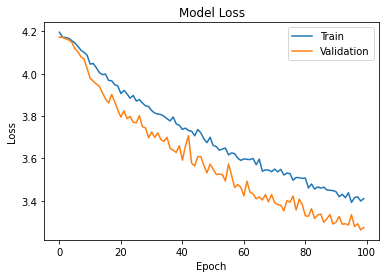

In [24]:
plot_loss(history)
plt.show()

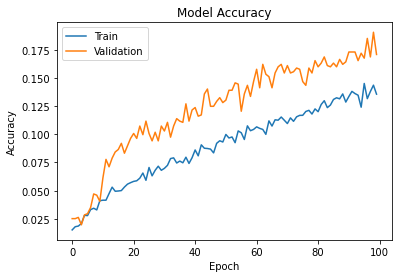

In [25]:
plot_acc(history)
plt.show()

In [26]:
predictions = model.predict(x_test)

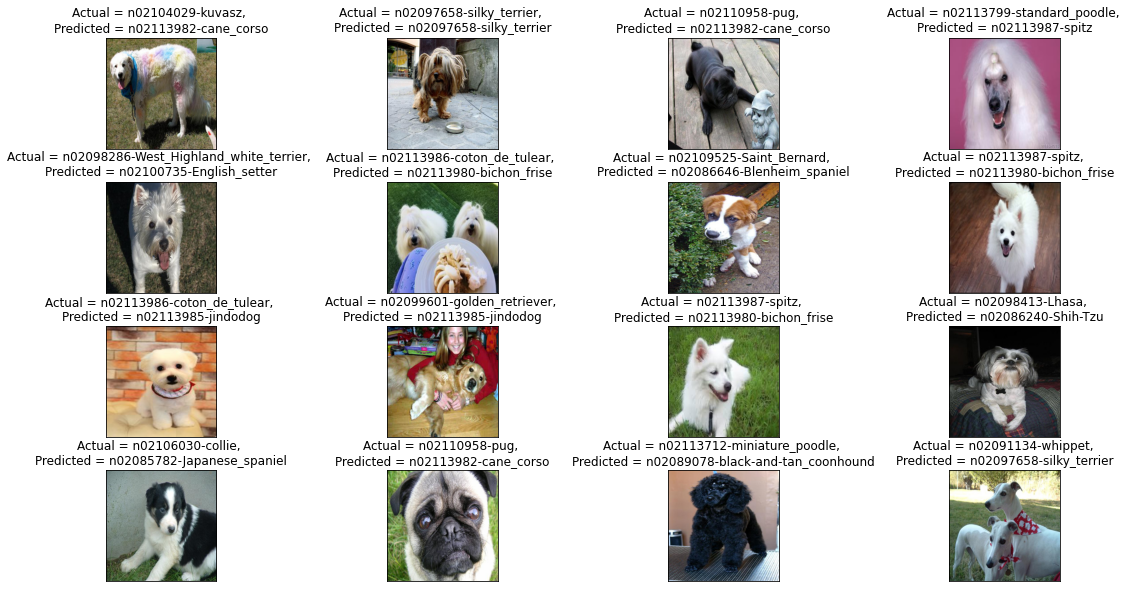

In [28]:
plt.figure(1 , figsize = (19 , 10))
n = 0 

for i in range(16):
    n += 1 
    r = np.random.randint( 0, x_test.shape[0], 1)
    
    plt.subplot(4, 4, n)
    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
    
    plt.imshow(x_test[r[0]])
    plt.title('Actual = {}, \nPredicted = {}'.format(categories[np.argpartition(y_test[r[0]],-1)[-1:][0]] , categories[np.argpartition(predictions[2][r[0]],-1)[-1:][0]]))
    plt.xticks([]) , plt.yticks([])

plt.show()